# CONTENT



[1](#1) EDA <br>
[2](#2) Предобработка данных <br>
[3](#3) Дамми модель <br>
[4](#4) Простые предсказания моделей <br>
[5](#5) Модели + кросс-валидация <br>
[6](#6) Подбор гиперпараметров<br>

[7](#7)

# Служебные импорты, настройки и функции

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 

warnings.filterwarnings('ignore')
rs = 56

In [2]:
# import sys
# !{sys.executable} -m pip install xgboost catboost

In [3]:
def simple_split_data(data):
    X = data.drop('survived', axis=1)
    y = data.survived

    return train_test_split(
        X, y, stratify=y, shuffle=True, random_state=rs
    ) 



def prepare_features(data):
    X, y = data.drop('survived', axis=1), data.survived
    X_train, X_test, y_train, y_test, = train_test_split(
        X, y, test_size=0.2, shuffle=True, stratify=y, random_state=rs)

    scaller = StandardScaler()
    scaller.fit(X_train[['fare']])
    X_train['fare'] = scaller.transform(X_train[['fare']])
    X_test['fare'] = scaller.transform(X_test[['fare']])

    cat_cols = ['p_class', 'sex', 'sib_sp', 'parch', 'embarked',
                'has_cabin', 'family_size', 'is_alone']
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoder.fit(X_train[cat_cols])
    encoded_train = pd.DataFrame(
        encoder.transform(X_train[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=X_train.index
    )
    
    encoded_test = pd.DataFrame(
        encoder.transform(X_test[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=X_test.index
    )

    X_train = pd.concat([X_train.drop(cat_cols, axis=1), encoded_train], axis=1)
    X_test =pd.concat([X_test.drop(cat_cols, axis=1), encoded_test], axis=1)
    
    return X_train, X_test, y_train, y_test


# 1

# EDA

[CONTENT](#CONTENT)<br>

## Загрузим данные и посмотрим на них глазами

In [4]:
data = pd.read_csv('data/train.csv')

In [5]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


#### Охарактеризуем данные по типу:
Дискретные числовые — p_class, sib_sp, parch, has_cabin

Непрерывные числовые — age, fare

Категориальные — sex, embarked, name, ticket


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Сразу приведем название колонок в соответствие с принятыми принципами и для удобства работы

In [8]:
data.columns = ['id', 'survived', 'p_class', 'name', 'sex', 'age', 'sib_sp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked']

data.columns

Index(['id', 'survived', 'p_class', 'name', 'sex', 'age', 'sib_sp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Построим попарные графики во взаимосвязи с таргетом и визуально посмотрим наличие/отсутсвие зависимостей между фичами, а также между фичами и таргетом

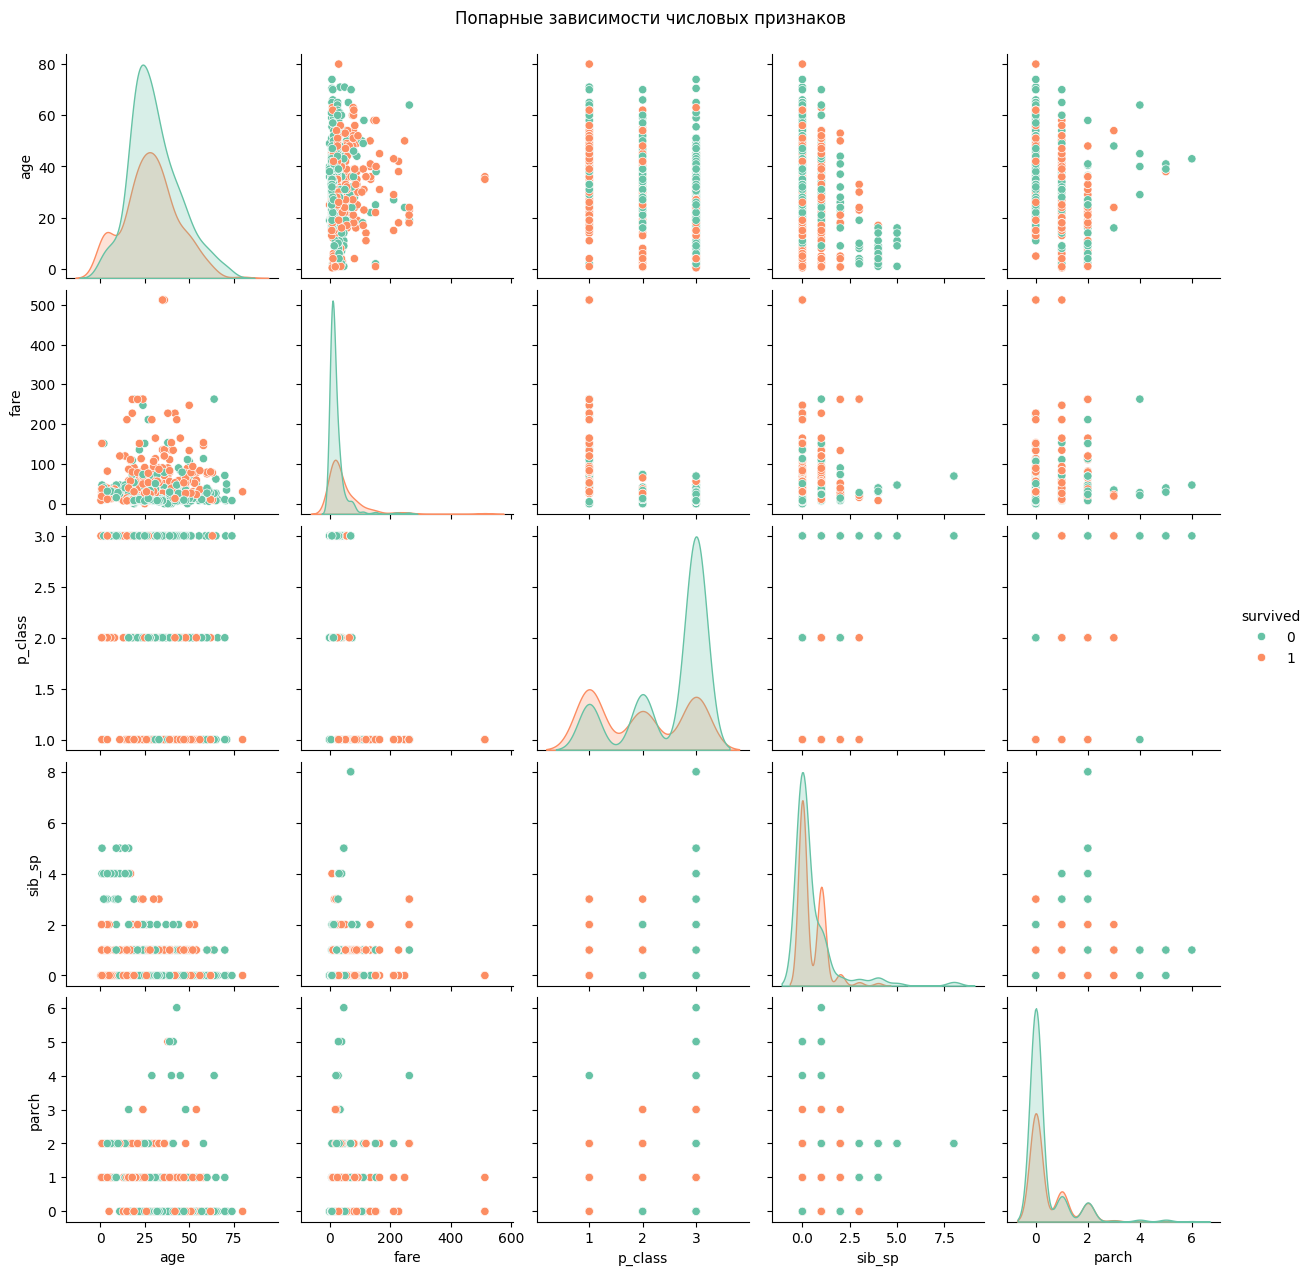

In [9]:
numeric_cols = ['age', 'fare', 'p_class', 'sib_sp', 'parch']

sns.pairplot(
    data=data[numeric_cols + ['survived']],
    hue="survived",
    palette="Set2",
    diag_kind="kde",
    height=2.5
)

plt.suptitle("Попарные зависимости числовых признаков", y=1.02)
plt.show()

### Визуально отмечаем:
- выраженную зависимость между классом и выживаемостью (только у первого класса доля выживших выше чем погибших, а у третьего доля погибших значительно выше, второй класс занимает промежуточное положение)
- аналгичная, но менее визуально заметная зависимость наблюдается в отношении стоимости билета
- у третьего больш всего родственников на борту, путешествовали большими семьями 

### Построим матрицу корреляции для того, чтобы проверить наши догадки по предыдущему разделу

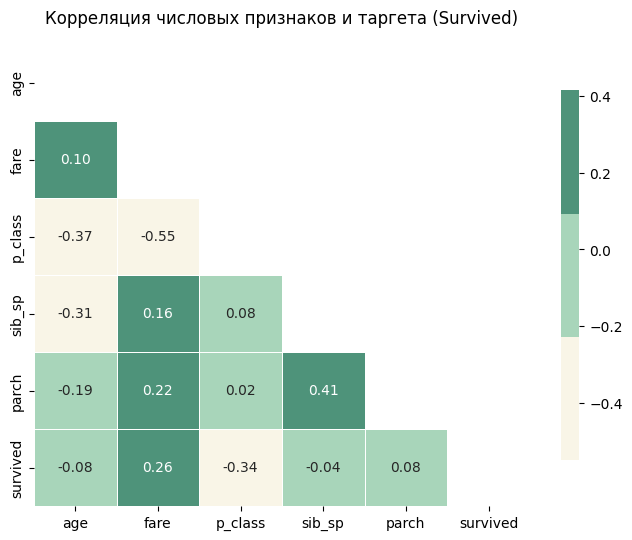

In [10]:
numeric_cols = ['age', 'fare', 'p_class', 'sib_sp', 'parch']

corr = data[numeric_cols + ['survived']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

custom_cmap = sns.color_palette(["#f9f5e7", "#a8d5ba", "#4e937a"])

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    mask=mask,
    cmap=custom_cmap,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Корреляция числовых признаков и таргета (Survived)", pad=15)
plt.show()


#### В целом догадки подвердили и наиболее высокая зависимость таргета наблюдается от класса 

При этом не обнаружено высоких (по модулю) значений корреляций между признакми, поэтому данные подходят для обучения даже линейных моделей 

#### Далее посмотрим зависимость таргета от пола (признак категориалоьный и ранее в графиках не рассматривался) 

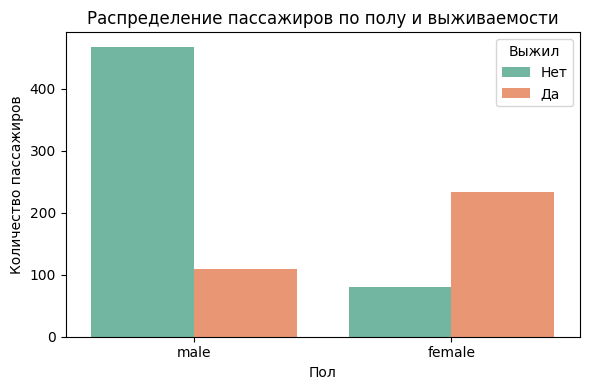

In [11]:
plt.figure(figsize=(6, 4))

sns.countplot(
    data=data,
    x='sex',
    hue='survived',
    palette='Set2'
)

plt.title('Распределение пассажиров по полу и выживаемости')
plt.xlabel('Пол')
plt.ylabel('Количество пассажиров')

plt.legend(title='Выжил', labels=['Нет', 'Да'], loc='upper right')

plt.tight_layout()
plt.show()

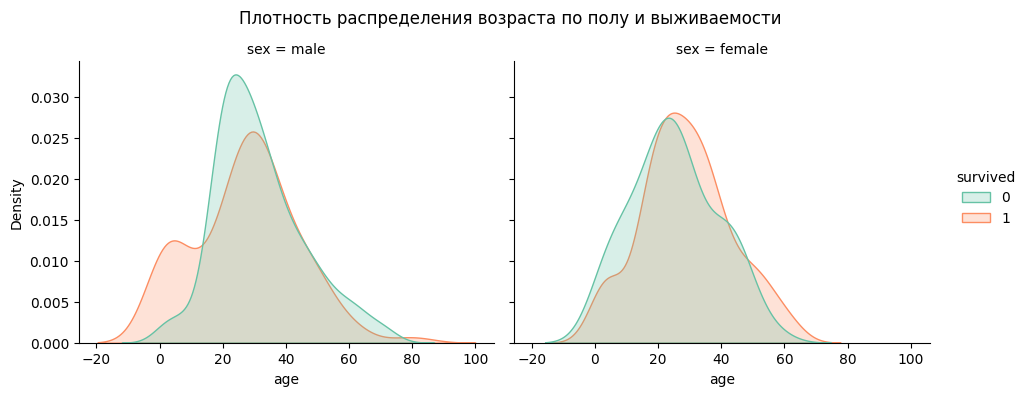

In [12]:
sns.displot(
    data=data,
    x='age',
    hue='survived',
    col='sex',
    kind='kde',
    fill=True,
    palette='Set2',
    height=4,
    aspect=1.2,
    common_norm=False  # важно: чтобы распределения не нормировались вместе
)

plt.subplots_adjust(top=0.85)
plt.suptitle('Плотность распределения возраста по полу и выживаемости')
plt.show()

#### Отмечаем что у женщин доля выживших намного выше, чем у мужчин

### Посмотрим боксплоты по числовым данным

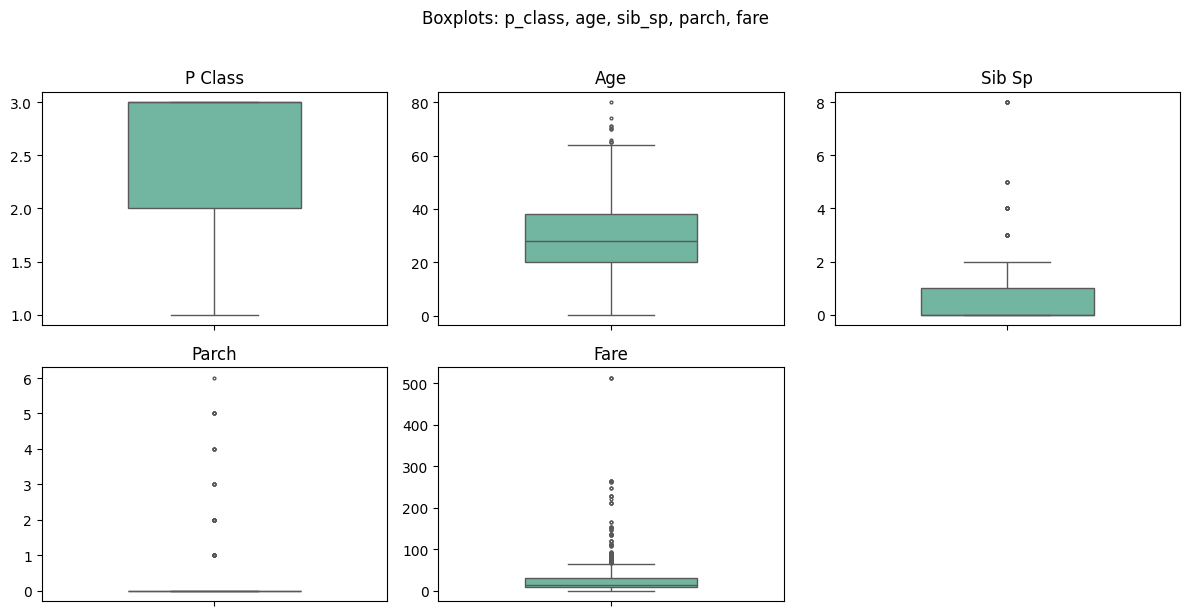

In [13]:
cols = ['p_class', 'age', 'sib_sp', 'parch', 'fare']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for i, c in enumerate(cols):
    sns.boxplot(
        data=data,
        y=c,
        ax=axes[i],
        color=sns.color_palette("Set2")[0],
        width=0.5,
        fliersize=2,
        linewidth=1
    )
    axes[i].set_title(c.replace('_', ' ').title())
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        axes[j].axis('off')

plt.suptitle('Boxplots: p_class, age, sib_sp, parch, fare', y=1.02)
plt.tight_layout()
plt.show()


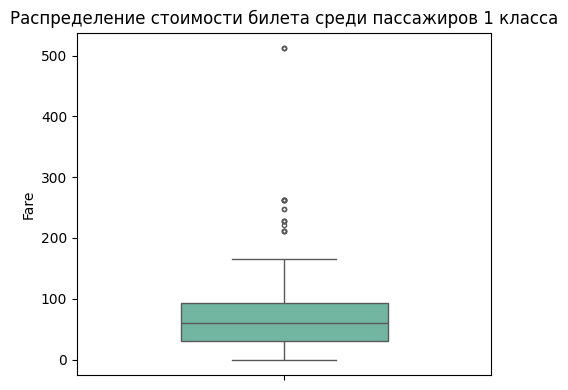

In [14]:
plt.figure(figsize=(5, 4))
sns.boxplot(
    data=data[data.p_class == 1],
    y='fare',
    color=sns.color_palette("Set2")[0],
    width=0.5,
    fliersize=3,
    linewidth=1
)

plt.title('Распределение стоимости билета среди пассажиров 1 класса')
plt.ylabel('Fare')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [15]:
first_class = data[data.p_class == 1]

q1 = first_class['fare'].quantile(0.25)
q3 = first_class['fare'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = first_class[
    (first_class['fare'] < lower_bound) | (first_class['fare'] > upper_bound)
]

n_outliers = outliers.shape[0]
total = first_class.shape[0]
share = n_outliers / total * 100

display('Количество выбросов в 1 классе =',  total)
display('Доля выбросов в 1 классе =',  share)

'Количество выбросов в 1 классе ='

216

'Доля выбросов в 1 классе ='

9.25925925925926

#### Среди пассажиров первого класса есть 216 со стоимостью проезда, которую можно отнести к выбросам 
Учитывая, что экстра дорогие каюты, действительно существуют. Считаем, что это не аномалия в данных, а особенность распредления, представленного в данных.


## Вывод:
- имеем небольшой датасет 891 строка
- в данных есть дискретные, числовые и категориальные типы данных
- таргет столбце survived бинарный то есть предстоит задача бинарной классификации
- доля положительного таргетного класса (1) 0.(38)
- имеются пропуски в столбцах age, cabin, embarked
- данные подходят для обучения в том числе линейных моделей
- отмечена высокая зависимость таргета от признака p_class, также повышает вероятность класса 1
  sex = female
- в признаке fare есть выбросы, связанные с индивидуальными очень дорогими билетами. Выбросы в остальных признаках могут быть объяснены небольшим количеством семей с большим количеством детей/родственников и большим количеством одиноко путешествующих.

# 2

# Предобработка данных

[CONTENT](#CONTENT)<br>

### Посмотрим визуально, что представляет из себя столбец cabin, чтобы принять решение о том, что делать с пропусками

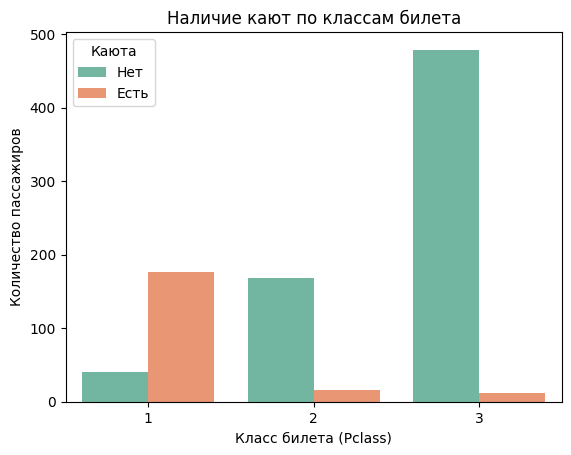

In [16]:
tmp = data.copy()
tmp['has_cabin'] = np.where(tmp.cabin.notnull(), 1, 0)

sns.countplot(
    data=tmp,
    x='p_class',
    hue='has_cabin',
    palette="Set2",
)
plt.title('Наличие кают по классам билета')
plt.xlabel('Класс билета (Pclass)')
plt.ylabel('Количество пассажиров')
plt.legend(title='Каюта', labels=['Нет', 'Есть'])
plt.show()

### Судя по графику, каюты были у наиболее обеспеченной части пассажиров. Третий класс был в общих помещениях. То есть пропуски в данном столбце в большинстве своем это не ошщибки в данных, а объективный критерий

Принимаем решение, удалить столбец каюты и просто оставить бинарный признак есть каюта или нет. При этом всему первому классу установим признак что каюта имеется. Сам номер каюты, если он есть, уникален и предсказательную способность не должен увеличить.

In [17]:
data['has_cabin'] = np.where(data.cabin.notnull() | data.p_class==1, 1, 0)
data = data.drop('cabin', axis=1)
data.sample(3)

,id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,embarked,has_cabin
191,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,S,1
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,S,1
534,535,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,S,1


### Ознакомимся с признаком age для принятия решения об обработке пропусков в нем

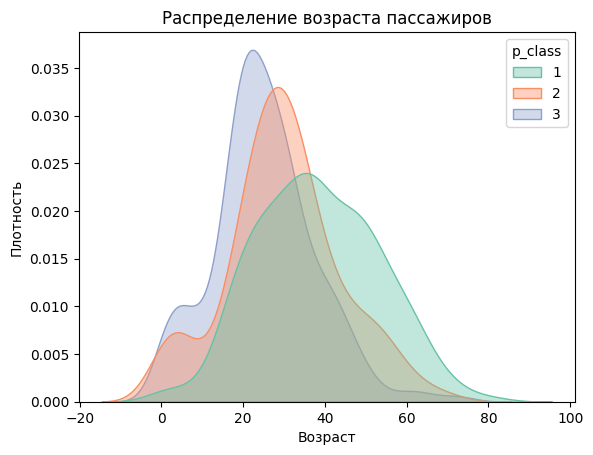

In [18]:
tmp = data.copy()

tmp['age_filled'] = tmp['age'].fillna(0)

tmp['age_is_missing'] = tmp['age'].isna().astype(int)

sns.kdeplot(
    data=tmp[tmp['age_filled'] > 0],
    x='age_filled',
    hue='p_class',
    common_norm=False,
    fill=True,
    palette='Set2',
    alpha=0.4
)


plt.title('Распределение возраста пассажиров')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.show()

#### Видим, что плотность распределения возраста разная для пассажиров разного класса

Заполним возраст, там где он пропущен, медианной по классу пассжиров

In [19]:
data.groupby('p_class')['age'].median()

p_class
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

In [20]:
(data[(data.p_class == 1) & (data.age.notna())]['age']).median()

37.0

In [21]:
data.age = data.age.fillna(
    data.groupby('p_class')['age'].transform('median')
)

display(data.info())
data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         891 non-null    int64  
 1   survived   891 non-null    int64  
 2   p_class    891 non-null    int64  
 3   name       891 non-null    object 
 4   sex        891 non-null    object 
 5   age        891 non-null    float64
 6   sib_sp     891 non-null    int64  
 7   parch      891 non-null    int64  
 8   ticket     891 non-null    object 
 9   fare       891 non-null    float64
 10  embarked   889 non-null    object 
 11  has_cabin  891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


None

,id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,embarked,has_cabin
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,S,1
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,C,1
488,489,0,3,"Somerton, Mr. Francis William",male,30.0,0,0,A.5. 18509,8.0500,S,1


### Пропущенные значения остались только в столбце embarked.

Это порт погрузки, заполним его просто значеним 'un'

In [22]:
data.embarked = data.embarked.fillna('un')

display(data.info())
data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         891 non-null    int64  
 1   survived   891 non-null    int64  
 2   p_class    891 non-null    int64  
 3   name       891 non-null    object 
 4   sex        891 non-null    object 
 5   age        891 non-null    float64
 6   sib_sp     891 non-null    int64  
 7   parch      891 non-null    int64  
 8   ticket     891 non-null    object 
 9   fare       891 non-null    float64
 10  embarked   891 non-null    object 
 11  has_cabin  891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


None

,id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,embarked,has_cabin
878,879,0,3,"Laleff, Mr. Kristo",male,24.0,0,0,349217,7.8958,S,1
425,426,0,3,"Wiseman, Mr. Phillippe",male,24.0,0,0,A/4. 34244,7.2500,S,1
281,282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,S,1


#### Принимаем решение удалить признак name
- он индивидуален и не несет сам по себе смысла для наших целей,
- вычленять из него доп признак наличие/отсуствие мужа  (по Mrs/Miss) некорректно, так как наличие мужа как такового не гарантирует его наличие на корабле в путешествии (аналогично с титулами мужчин)

#### Принимаем решение удалить признак ticket
- принадлежность класса можно установить по другим признакам, а сам посебе признак содержит уникальное значение, не влияющее на предсказание

### Принимаем решение удалить признак id
- он не несет для нас смысла, так как четко привязан к конкретному человеку и не увеличит предсказательную способность модели

#### Признак пола заменим на 0 (женщины) и 1 (мужчины)

In [23]:
data = data.drop(['ticket', 'name', 'id'],axis=1)


data.sex = np.where(data.sex=='male', 1, 0)

data.sample()

,survived,p_class,sex,age,sib_sp,parch,fare,embarked,has_cabin
491,0,3,1,21.0,0,0,7.25,S,1


### На основе столбцов sib_sp и parch сгенерируем столбцы is_alone и family_size и сразу визуально посмотрим влияет ли это на таргет

In [24]:
data['family_size'] = data.sib_sp + data.parch + 1
data['is_alone'] = np.where(data.family_size==1, 1, 0)

data.sample()

,survived,p_class,sex,age,sib_sp,parch,fare,embarked,has_cabin,family_size,is_alone
750,1,2,0,4.0,1,1,23.0,S,1,3,0


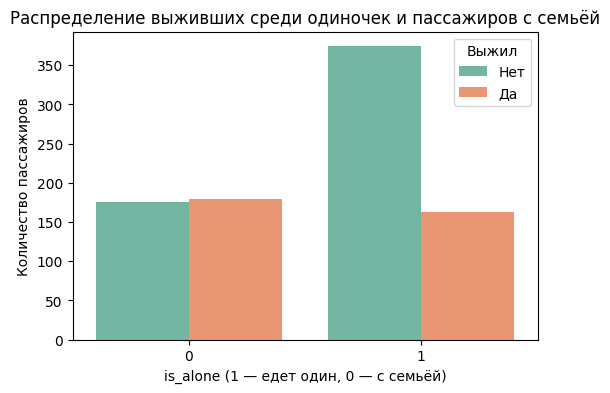

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=data,
    x='is_alone',
    hue='survived',
    palette='Set2'
)

plt.title('Распределение выживших среди одиночек и пассажиров с семьёй')
plt.xlabel('is_alone (1 — едет один, 0 — с семьёй)')
plt.ylabel('Количество пассажиров')

plt.legend(
    title='Выжил',
    labels=['Нет', 'Да'],
    loc='upper right'
)
plt.show()

### Вывод:
- подготовили данные для обучения моделей
- заполнили пропуски
- удалили неактуальные стобцы
- сгенерировали два дополнтительных признака is_alone и family_size

# 3

[CONTENT](#CONTENT)<br>

# Дамми модель

#### Подготовим данные для обучения и обучим дамми модель

Дамми модель будет всегда предсказывать саммый представленный класс. Нужна для того, чтобы сравнивать с ней наши рабочие модели и понимать достигаем ли мы прогресса

Создадим датафрейм для хранения все результатов обучения

In [26]:
X = data.drop('survived', axis=1)
y = data.survived


display(X.head(2), y.head(4))

,p_class,sex,age,sib_sp,parch,fare,embarked,has_cabin,family_size,is_alone
0,3,1,22.0,1,0,7.2500,S,1,2,0
1,1,0,38.0,1,0,71.2833,C,1,2,0


0    0
1    1
2    1
3    1
Name: survived, dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

dummy_mod = DummyClassifier(strategy='most_frequent', random_state=rs)
dummy_mod.fit(X_train, y_train)

y_pred = dummy_mod.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6145251396648045

In [28]:
results = pd.DataFrame({
    'name': ['dummy_mod'],
    'model': [dummy_mod],
    'accuracy': [accuracy]
}
)

results

,name,model,accuracy
0,dummy_mod,"DummyClassifier(random_state=56, strategy='mos...",0.614525


### Вывод:
- обучили дамми модель с accuracy 0,6145
- сохраниоли модель и скорринг в самостоятельный датафрейм

# 4

# Простые предсказания моделей

[CONTENT](#CONTENT)<br>

#### Стандартизируем данные столбца fare, так как они имеют выборосы, и закодируем категориальные данные (см. функцию в начале ноутбука)

In [29]:
# перенесено в кастомную функцию, повторяющийся код - not dry
# X = data.drop('survived', axis=1)
# y = data.survived
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)


# scaller = StandardScaler()
# scaller.fit(X_train[['fare']])
# scaller.transform(X_train[['fare']])
# scaller.transform(X_test[['fare']])


# cat_columns = ['p_class', 'sex', 'sib_sp', 'parch', 'embarked',
#        'has_cabin', 'family_size', 'is_alone']
# encoder = OneHotEncoder(drop='first', sparse_output=False)
# encoder.fit(X_train[cat_columns])

# encoded_train = encoder.transform(X_train[cat_columns])
# encoded_test = encoder.transform(X_test[cat_columns])

# encoded_train = pd.DataFrame(
#     encoder.transform(X_train[cat_columns]),
#     columns=encoder.get_feature_names_out(cat_columns),
#     index=X_train.index
# )
# encoded_test = pd.DataFrame(
#     encoder.transform(X_test[cat_columns]),
#     columns=encoder.get_feature_names_out(cat_columns),
#     index=X_test.index
# )


# X_train = pd.concat([X_train.drop(cat_columns, axis=1), encoded_train], axis=1)
# X_test = pd.concat([X_test.drop(cat_columns, axis=1), encoded_test], axis=1)

#### LogisticRegression

In [30]:
X_train, X_test, y_train, y_test = prepare_features(data)

log_reg = LogisticRegression(random_state=rs)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

results.loc[len(results)] = ['logistic_regession', log_reg, accuracy]

In [31]:
results

,name,model,accuracy
0,dummy_mod,"DummyClassifier(random_state=56, strategy='mos...",0.614525
1,logistic_regession,LogisticRegression(random_state=56),0.770950


### RandomForestClassifier

In [32]:
X_train, X_test, y_train, y_test = prepare_features(data)

random_forest =  RandomForestClassifier(random_state=rs)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

results.loc[len(results)] = ['random_forest', random_forest, accuracy]

In [33]:
results

,name,model,accuracy
0,dummy_mod,"DummyClassifier(random_state=56, strategy='mos...",0.614525
1,logistic_regession,LogisticRegression(random_state=56),0.770950
2,random_forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.754190


## XGBoost

In [34]:
X_train, X_test, y_train, y_test = prepare_features(data)

xgboost = XGBClassifier(random_state=rs)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
results.loc[len(results)] = ['xgboost_classifier', xgboost, accuracy]

In [35]:
results

,name,model,accuracy
0,dummy_mod,"DummyClassifier(random_state=56, strategy='mos...",0.614525
1,logistic_regession,LogisticRegression(random_state=56),0.770950
2,random_forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.754190
3,xgboost_classifier,"XGBClassifier(base_score=None, booster=None, c...",0.782123


## Catboost

In [36]:
X_train, X_test, y_train, y_test = prepare_features(data)

catbost_classifier = CatBoostClassifier(random_state=42, verbose=0)
catbost_classifier.fit(X_train, y_train)
y_pred = catbost_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

results.loc[len(results)] = ['catbost_classifier', catbost_classifier, accuracy]

In [37]:
results

,name,model,accuracy
0,dummy_mod,"DummyClassifier(random_state=56, strategy='mos...",0.614525
1,logistic_regession,LogisticRegression(random_state=56),0.770950
2,random_forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.754190
3,xgboost_classifier,"XGBClassifier(base_score=None, booster=None, c...",0.782123
4,catbost_classifier,<catboost.core.CatBoostClassifier object at 0x...,0.782123


In [38]:
same_predictions = np.mean(xgboost.predict(X_test) == catbost_classifier.predict(X_test))
print(f"Совпадение предсказаний: {same_predictions:.4f}")

Совпадение предсказаний: 0.8771


# 5

# Модели + кросс-валидация

#### LogisticRegression

In [39]:
X_train, X_test, y_train, y_test = prepare_features(data)

cv = StratifiedKFold(n_splits=5, shuffle=True,  random_state=rs)

log_reg_cv = LogisticRegression(random_state=rs)


accuracy = cross_val_score(log_reg_cv, X_train, y_train, cv=cv)

#y_pred = cross_val_predict(log_reg_cv, X_train, y_train, cv=cv)
#accuracy = accuracy_score(y_train, y_pred)

results.loc[len(results)] = ['log_reg_cv', log_reg_cv, accuracy]

#### RandomForestClassifierCV

In [40]:
X_train, X_test, y_train, y_test = prepare_features(data)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

random_forest_cv = RandomForestClassifier(random_state=rs)

accuracy = cross_val_score(random_forest_cv, X_train, y_train, cv=cv)

# y_pred = cross_val_predict(random_forest_cv, X_train, y_train, cv=cv)
# accuracy = accuracy_score(y_train, y_pred)

results.loc[len(results)] = ['random_forest_cv', random_forest_cv, accuracy]

#### XGBoost

In [41]:
X_train, X_test, y_train, y_test = prepare_features(data)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

xgboost_cv = XGBClassifier(random_state=rs)
accuracy = cross_val_score(xgboost_cv, X_train, y_train, cv=cv)

# y_pred = cross_val_predict(xgboost_cv, X_train, y_train, cv=cv)
# accuracy = accuracy_score(y_train, y_pred)

results.loc[len(results)] = ['xgboost_cv', xgboost_cv, accuracy]

#### Catboost

In [49]:
X_train, X_test, y_train, y_test = prepare_features(data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

catboost_cv = CatBoostClassifier(random_state=rs, verbose=0)
accuracy = cross_val_score(catboost_cv, X_train, y_train, cv=cv)

results.loc[len(results)] = ['catboost_cv', catboost_cv, accuracy]

In [50]:
results

,name,model,accuracy
0,dummy_mod,"DummyClassifier(random_state=56, strategy='mos...",0.614525
1,logistic_regession,LogisticRegression(random_state=56),0.77095
2,random_forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.75419
3,xgboost_classifier,"XGBClassifier(base_score=None, booster=None, c...",0.782123
4,catbost_classifier,<catboost.core.CatBoostClassifier object at 0x...,0.782123
5,log_reg_cv,LogisticRegression(random_state=56),"[0.8111888111888111, 0.8601398601398601, 0.760..."
6,random_forest_cv,RandomForestClassifier(random_state=56),"[0.7902097902097902, 0.8321678321678322, 0.760..."
7,xgboost_cv,"XGBClassifier(base_score=None, booster=None, c...","[0.8111888111888111, 0.8181818181818182, 0.767..."
8,catboost_cv,<catboost.core.CatBoostClassifier object at 0x...,"[0.8391608391608392, 0.8671328671328671, 0.774..."


# 7

[CONTENT](#CONTENT)<br>